In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.distributed as dist
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [2]:
from nets.SegRank import SegRank
from data import PlacePulseDataset, AdaptTransform
from train_scripts.SegRank import train
import seg_transforms

In [3]:
## Constants
PLACE_PULSE_PATH ='votes'
IMAGES_PATH= 'pp_cropped/'
MODEL_PATH = 'models/segrank_resnet_wealthy_15_acc_model_0.6199546307884856.pth'
IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)
ATTRIBUTE='wealthy_orig'
BATCH_SIZE = 1
CS_CLASSES = [
    'road',
    'sidewalk',
    'building',
    'wall',
    'fence',
    'pole',
    'traffic light',
    'traffic sign',
    'vegetation',
    'terrain',
    'sky',
    'person',
    'rider',
    'car',
    'truck',
    'bus',
    'train',
    'motorcycle',
    'bicycle'
]
N_LAYERS=1
N_HEADS=1
SOFTMAX=True

## Setup Network

In [4]:
transformers = transforms.Compose([
        AdaptTransform(seg_transforms.ToArray()),
        AdaptTransform(seg_transforms.SubstractMean(IMG_MEAN)),
        AdaptTransform(seg_transforms.Resize((244,244))),
        AdaptTransform(seg_transforms.ToTorchDims())
        ])

dataset=PlacePulseDataset(
    f'{PLACE_PULSE_PATH}/{ATTRIBUTE}/val.csv',
    IMAGES_PATH,
    transform=transformers,
    return_images=True
    )

loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=1, drop_last=True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dist.init_process_group('gloo', init_method='file:///tmp/tmpfile', rank=0, world_size=1)

In [6]:
net = SegRank(image_size=(244,244), n_layers=N_LAYERS, n_heads=N_HEADS, softmax=SOFTMAX)
net.load_state_dict(torch.load(MODEL_PATH, map_location=device))
net.eval()
print('loaded')

loaded


## Forward Pass

In [7]:
batch = next(iter(loader))
input_left, input_right, label, left_original = batch['left_image'], batch['right_image'], batch['winner'], batch['left_image_original']
label

tensor([1])

In [8]:
torch.set_printoptions(precision=15)

with torch.no_grad():
    forward_dict = net(input_left,input_right)
    output_rank_left, output_rank_right =  forward_dict['left']['output'], forward_dict['right']['output']
output_rank_left, output_rank_right

(tensor([[2.149845600128174]]), tensor([[2.985937833786011]]))

## Image visualization

In [199]:
from PIL import Image as PILImage
from torch import nn
import cv2

def segmentation_to_image(segmentation,image,palette, output_size=(244, 244)):
    grayed = gray_image(image,output_size)
    interp = nn.Upsample(size=output_size, mode='bilinear', align_corners=True)
    segmentation = interp(segmentation.unsqueeze(0)).cpu().numpy().transpose(0,2,3,1)
    seg_pred = np.asarray(np.argmax(segmentation, axis=3), dtype=np.uint8)
    output_im = PILImage.fromarray(seg_pred[0])
    output_im.putpalette(palette)
    output_im = output_im.convert('RGB')
    result = cv2.addWeighted(np.array(output_im), 0.7, grayed, 0.3, 0)
    return result

def attention_to_images(image,attention_map,output_size=(244,244), normalize='local'):
    interp = nn.Upsample(size=output_size, mode='bilinear', align_corners=True)
    cvImage = gray_image(image,output_size)
    attention_map = interp(attention_map).squeeze(1).cpu().detach().numpy()
    ticks=[(attention_map.min()),(attention_map.max())]
    normalized = global_normalize(cvImage, attention_map) if normalize == 'global' else local_normalize(cvImage, attention_map) 
    return normalized, ticks

def shape_attention(attention_map):
    attention_map = attention_map[:,:,:]
    attention_map = attention_map.mean(dim=1, keepdim=True).permute([0,2,1])
    attention_size = attention_map.size()
    dim = int(attention_size[1]**(0.5))
    attention_map = attention_map.permute([0,2,1]).view((attention_size[0],1,dim,dim))
    return attention_map
    
def gray_image(image,output_size):
    cvImage = cv2.cvtColor(image.cpu().numpy(), cv2.COLOR_RGB2BGR)
    cvImage = cv2.cvtColor(cvImage, cv2.COLOR_BGR2GRAY)
    cvImage = cv2.cvtColor(cvImage, cv2.COLOR_GRAY2BGR) #we neeed a 3 dimensional gray image
    cvImage = cv2.resize(cvImage, output_size)
    return cvImage

def global_normalize(image,attention_map, mask_value=0):
    images = []
    heatmap_img = None
    heatmap_img = normalize_attention(attention_map, mask_value)
    for single_map in heatmap_img:
        single_img = cv2.applyColorMap(single_map, cv2.COLORMAP_JET)
        result = cv2.addWeighted(single_img, 0.5, image, 0.5, 0)
        result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
        images.append(result)
    return images

def local_normalize(image,attention_map, mask_value=0):
    images = []
    for single_map in attention_map:
        heatmap_img = None
        heatmap_img = normalize_attention(single_map, mask_value)
        img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)
        result = cv2.addWeighted(img, 0.5, image, 0.5, 0)
        result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
        images.append(result)
    return images

def normalize_attention(attention, mask_value=-1):
    input_min = np.min(attention[attention > mask_value])
    input_max = attention.max()
    return (np.maximum((attention - input_min),0)/(input_max - input_min) * 255).astype('uint8')

def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """

    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette

def image_log(segmentation,original,attention_map,palette, normalize='local'):
    seg_img = segmentation_to_image(segmentation, original, palette)
    attentions, ticks = attention_to_images(original, attention_map, normalize=normalize)
    return seg_img, attentions, ticks


def masked_attention_images(original,segmentation, attention_map, output_size=(244,244)):
    interp = nn.Upsample(size=output_size, mode='bilinear', align_corners=True)
    seg= interp(segmentation.unsqueeze(0)).permute([0,1,2,3]).squeeze(0)
    seg = torch.from_numpy(np.asarray(np.argmax(seg, axis=0), dtype=np.uint8)).long()
    seg = torch.nn.functional.one_hot(seg, num_classes=19).permute([2,0,1]).float()
    attention_matrix = interp(attention_map).squeeze()
    masked = torch.mul(seg, attention_matrix).numpy()
    cvImage = gray_image(original,output_size)
    return masked, np.array(global_normalize(cvImage, masked, 0))

def show_layout(images, titles=None, ticks = None):
    aux_titles = titles if titles is not None else {}
    fig = plt.figure(figsize=(25, 50))
    cmap = mpl.cm.Spectral_r
    for i in range(len(images)):
        sub = fig.add_subplot(11, 4, i + 1)
        sub.axis('off')
        if i < len(aux_titles):
            sub.set_title(titles[i])
        img = sub.imshow(images[i], interpolation='nearest')
        if i > 1 and i - 2 < len(ticks):
            norm = mpl.colors.Normalize(vmin=ticks[i][0], vmax=ticks[i][-1])
            cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=sub)
            tick_locator = mpl.ticker.LinearLocator(5)
            cbar.set_ticks(tick_locator)
            cbar.update_ticks()

In [207]:
batch = next(iter(loader))
input_left, input_right, label, left_original = batch['left_image'], batch['right_image'], batch['winner'], batch['left_image_original']
with torch.no_grad():
    forward_dict = net(input_left,input_right)
    output_rank_left, output_rank_right =  forward_dict['left']['output'], forward_dict['right']['output']

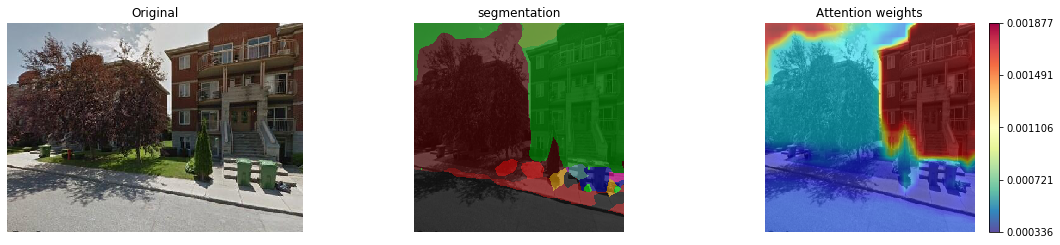

In [208]:
torch.set_printoptions(precision=10)

segmentation = forward_dict['left']['segmentation'][0]
original = left_original[0]
normalize='local'
titles = {
    0: 'Original',
    1: 'segmentation'
}
ticks = {}
seg_classes = np.argmax(segmentation, axis=0)
attention_map = shape_attention(forward_dict['left']['attention'][0][0])
seg_img, attentions, _ticks = image_log(segmentation,original,attention_map,get_palette(19), normalize)
titles[2] = f'Attention weights'
ticks[2] = _ticks
show_layout([original,seg_img] + attentions, titles, ticks)

## Attention masked segmentation

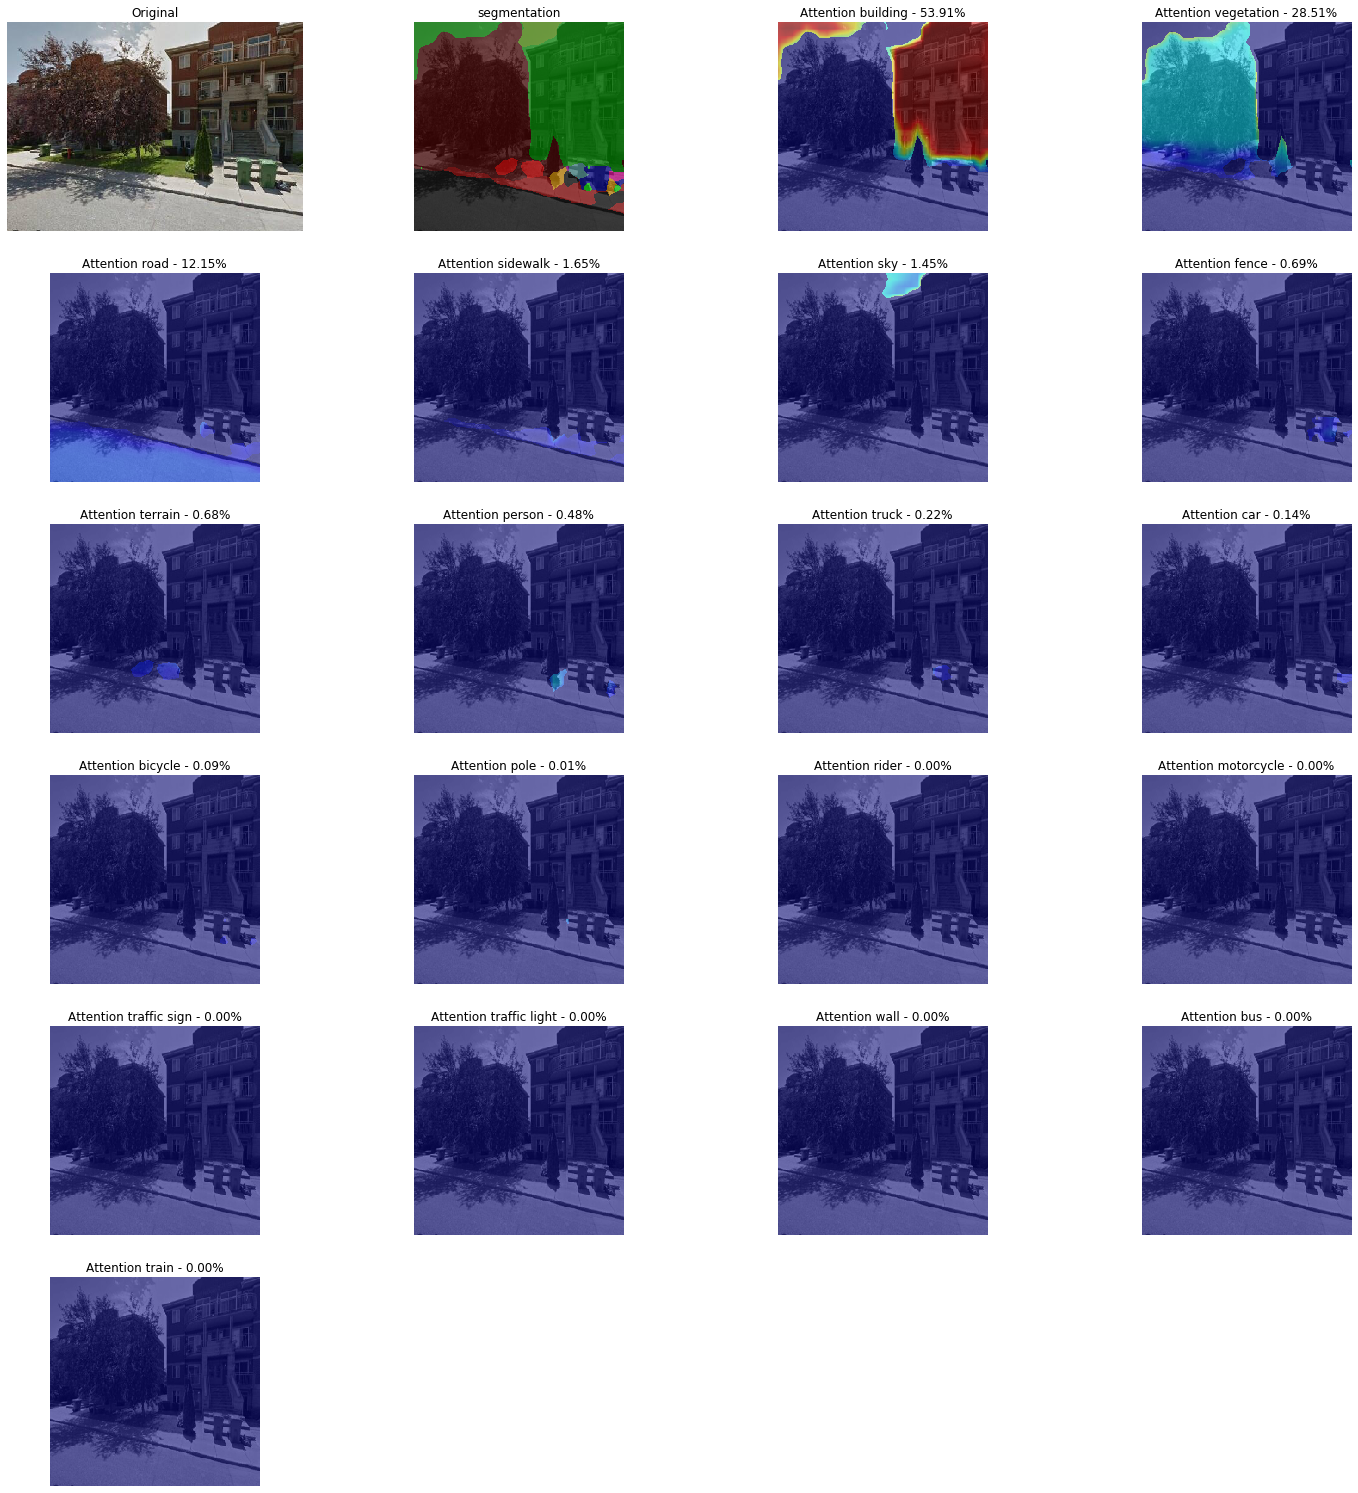

In [209]:
attn_mattrix = attention_map.squeeze()
titles = {
    0: 'Original',
    1: 'segmentation'
}
masked, images = masked_attention_images(original,segmentation, attention_map)
seg_img = segmentation_to_image(segmentation, original, get_palette(19))

sums = np.fromiter(map(lambda x: x.sum(), masked),dtype=np.float)
total = masked.sum()
sorted_idx = sums.argsort()[::-1]
for i, idx in enumerate(sorted_idx):
    titles[i + 2] = f'Attention {CS_CLASSES[idx]} - {(masked[idx].sum() * 100 / total):.2f}%'
images = list(images[sorted_idx])
show_layout([original,seg_img] + images, titles, [])

## Visualize attributes

In [ ]:
MODELS = {
    'wealthy':'models/segrank_resnet_wealthy_15_model_33.pth',
    'depressing': 'models/segrank_resnet_depressing_15_model_5.pth',
    'safety': 'models/segrank_resnet_safety_15_model_34.pth',
    'boring': 'models/segrank_resnet_boring_15_model_14.pth',
    'lively': 'models/segrank_resnet_lively_15_model_20.pth',
    'beautiful':'models/segrank_resnet_beautiful_15_model_9.pth',
}

In [ ]:
torch.set_printoptions(precision=10)
batch = next(iter(loader))
input_left, input_right, label, left_original = batch['left_image'], batch['right_image'], batch['winner'], batch['left_image_original']
original = left_original[0]
titles = ['Original', 'Segmentation']
total_attentions = []
ticks = [None,None]
normalize='local'
for attribute, path in MODELS.items():
    net = SegRank(image_size=(244,244), n_layers=N_LAYERS, n_heads=N_HEADS, softmax=SOFTMAX)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    with torch.no_grad():
        forward_dict = net(input_left,input_right)
        output_rank_left, output_rank_right =  forward_dict['left']['output'], forward_dict['right']['output']
    
    segmentation = forward_dict['left']['segmentation'][0]
    seg_classes = np.argmax(segmentation, axis=0)
    attention_map = shape_attention(forward_dict['left']['attention'][0][0])
    seg_img, attentions, _ticks = image_log(segmentation,original,attention_map,get_palette(19), normalize)
    total_attentions += attentions
    for i in range(len(attentions)):
        titles.append(attribute.capitalize())
        ticks.append(_ticks)

show_layout([original,seg_img] + total_attentions, titles, ticks)